## Hong Benchmark Linear only

* Benchmark Hong 

## Inputs

(0, 'i_u1')

(1, 'i_u2')



## Outputs


(0, 'o_y')




In [1]:


import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch

from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [2]:

import PDFshapingUtils as PDF_tk


In [3]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()


## Impulse Function Target

In [4]:

PDFshapingOBJ.initializeImpulseGaussian()
## PDFshapingOBJ.initializeImpulseToOtherShapes()                ## debug only, remove rc

print(PDFshapingOBJ.x_range_impulse_func )
print(PDFshapingOBJ.impulse_func_vector_vals )
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


tensor([-20.0000, -19.9900, -19.9800,  ...,  19.9700,  19.9800,  19.9900])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([4000])
torch.Size([4000])
tensor(100.0000)


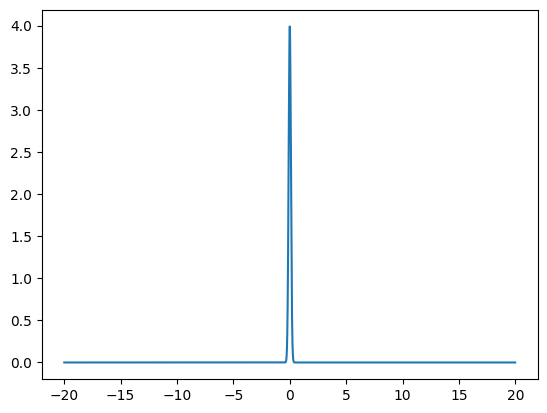

In [5]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()


## This is just to test with fake data the KDE

torch.Size([400, 5])


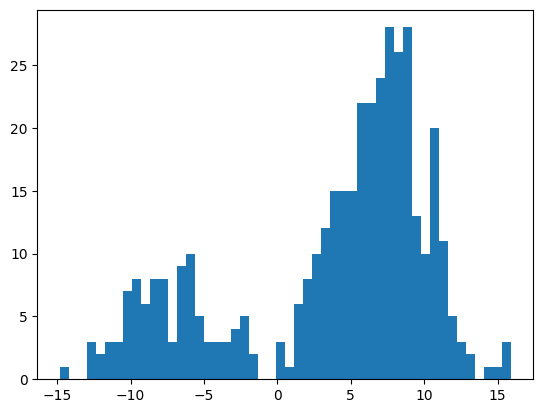

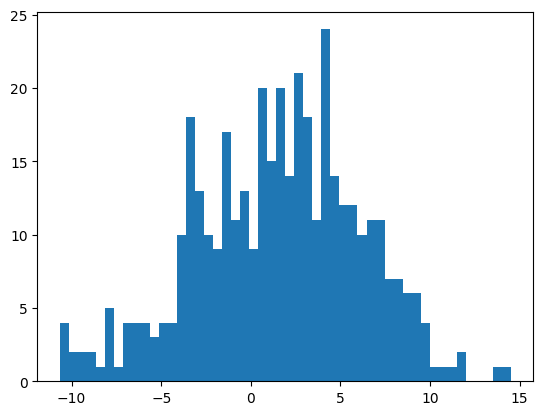

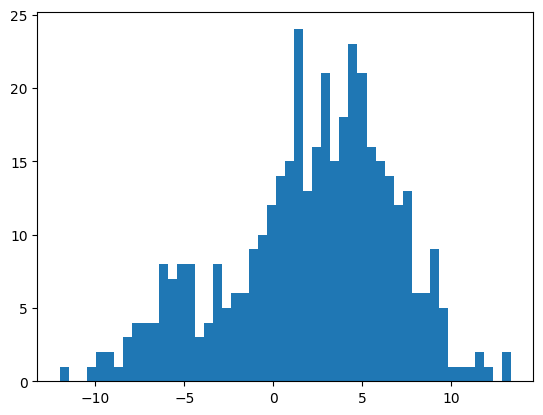

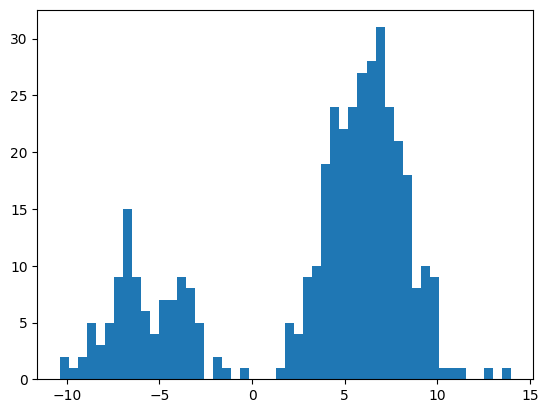

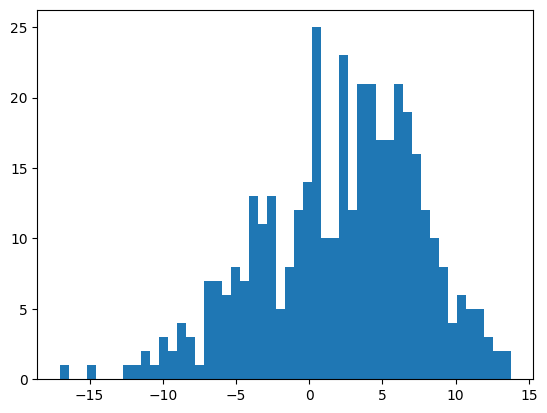

torch.Size([400, 5])
tensor([[     8.6096,     11.7246,      5.8762,      5.5511,      6.7365],
        [     5.9158,      4.1750,      5.6699,      5.0289,      4.5781],
        [     8.0183,      3.2042,      7.0899,      6.1337,      0.0044],
        ...,
        [    -8.1231,     -2.6180,      2.4626,     -4.4415,      1.5459],
        [    -9.7882,     -1.4921,     -2.7194,     -3.1621,     -6.1269],
        [    -6.1550,     -4.3732,     -9.1247,    -10.2768,     -0.7929]],
       dtype=torch.float64)
5
0
torch.Size([400])
1
torch.Size([400])
2
torch.Size([400])
3
torch.Size([400])
4
torch.Size([400])
torch.Size([4000, 5])


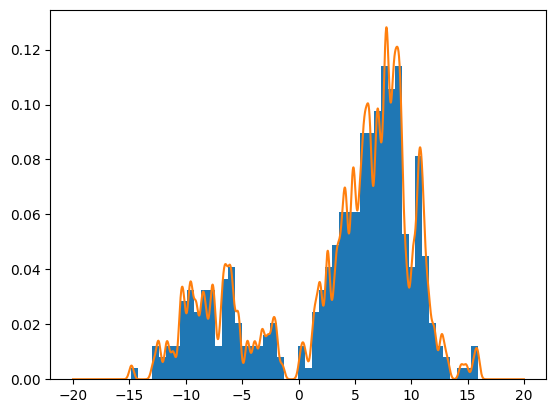

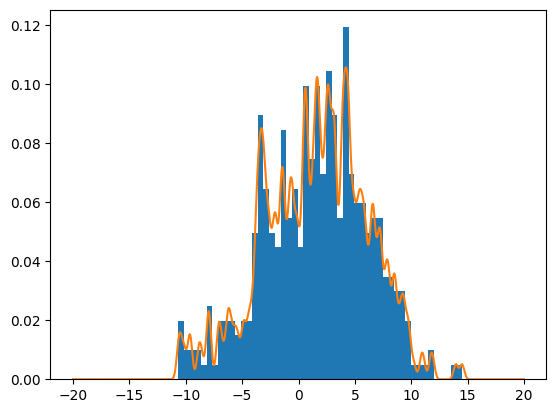

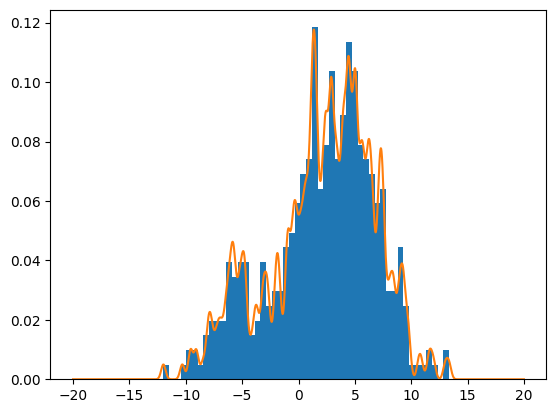

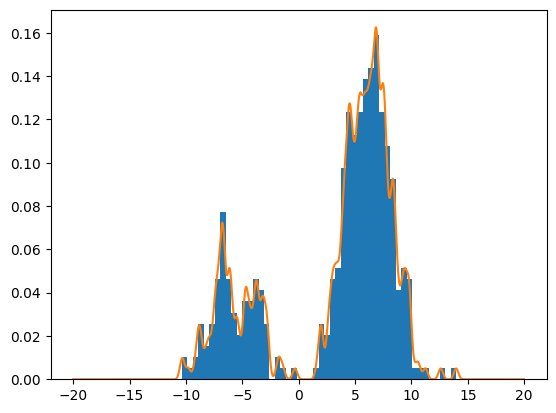

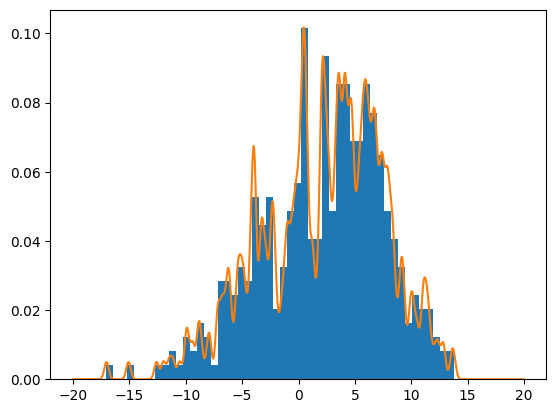

tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)


In [6]:

PDFshapingOBJ.test_torchKDE_with_fake_data()


In [7]:

PDFshapingOBJ.read_csv_file_with_pandas('benchmarks/BenchmarkDataHong.csv')


In [8]:
PDFshapingOBJ.CFD_raw_data

,i_u1,i_u2,o_y
0,0.000077,1.2406,10.0000
1,0.000238,1.0155,10.0000
2,0.000740,1.3879,10.0010
3,0.001617,1.0262,10.0020
4,0.003202,1.9126,10.0020
...,...,...,...
995,51.626000,34.4560,11.4980
996,20.462000,28.9600,10.7070
997,37.754000,26.4760,11.4260
998,-10.288000,35.7610,9.7123


In [9]:

PDFshapingOBJ.print_headers_list()


['i_u1', 'i_u2', 'o_y']
3
(0, 'i_u1')
(1, 'i_u2')
(2, 'o_y')


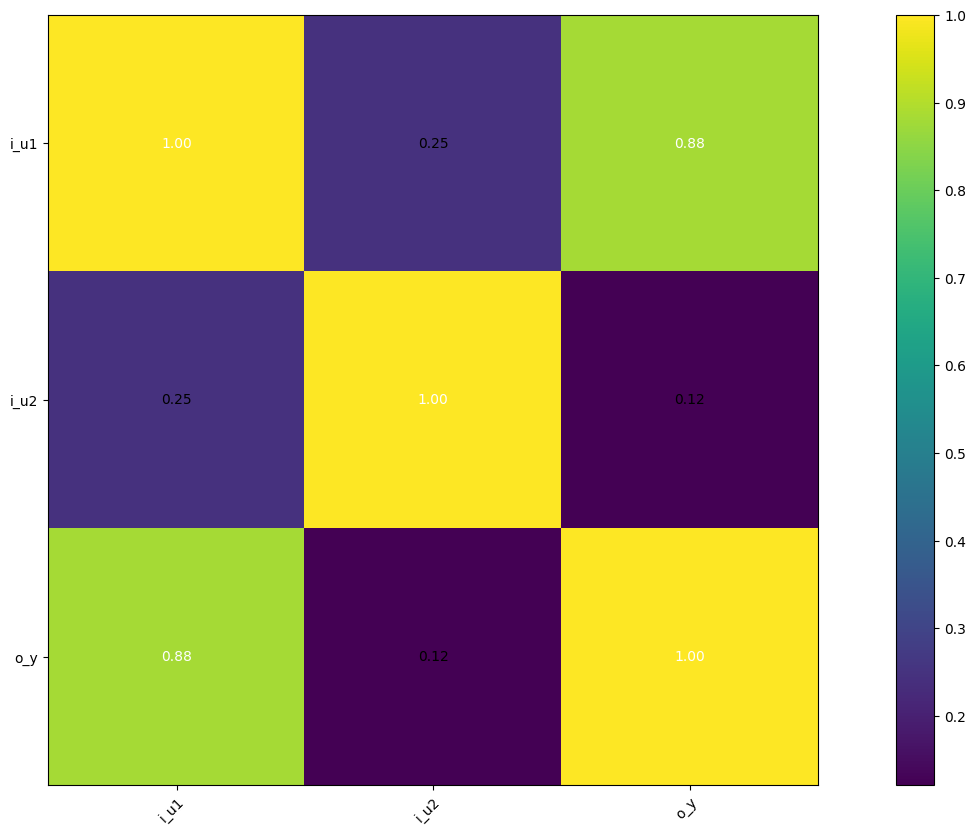

In [10]:

PDFshapingOBJ.list_of_selected_column_names = ['i_u1', 'i_u2', 'o_y']

PDFshapingOBJ.print_correlation_coefficients()


In [11]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  0.0000774    1.2406      10.        ]
 [  0.00023827   1.0155      10.        ]
 [  0.00073993   1.3879      10.001     ]
 ...
 [ 37.754       26.476       11.426     ]
 [-10.288       35.761        9.7123    ]
 [-63.098       30.914        7.9589    ]]
(1000, 3)


In [12]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs=[0, 1] , 
                   outputs=[2]   
)


2
1


In [13]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)



(1000, 2)
(1000, 1)


In [14]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [15]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(800, 2)
(200, 2)
(800, 1)
(200, 1)


In [16]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [17]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [18]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


## NN architectures

In [19]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.zeros_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.zeros_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################


In [21]:


#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(2, 1)       
        
        ## F2
        self.f2_linear1 = nn.Linear(2, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 1)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



In [22]:

class SigmaNN(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        
     
        self.linear1 = nn.Linear(4000, 1000)
        self.act1    = nn.Sigmoid()          ## nn.Tanh()          ## Sigmoid()       nn.GELU()  
        self.linear2 = nn.Linear(1000, 500)
        self.act2    = nn.Sigmoid()         ## nn.Tanh()          ## Sigmoid()       nn.GELU()   
        self.linear3 = nn.Linear(500, 24000)   
        self.act3    = nn.Sigmoid() 
        self.dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
     
        f = self.linear1(x)
        f = self.act1(f)
        f = self.dropout(f)
        f = self.linear2(f)
        f = self.act2(f)
        f = self.dropout(f)
        f = self.linear3(f)
        f = self.act3(f)
 
        return f
    

In [23]:

def my_loss_UNKNOWN_error_PDF(epoch, output, target):
    error = output.float() - target.float()                            ## 400 X 5
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)        ## 4000 X 1
    basisFunc = train_multiple_kernels_per_output(x, error, bandwidth)    ## 4000 x 5
    
    if epoch % 50 == 0:
        print_errors_kdes(error, x, basisFunc)
        print(impulseFunc.shape)
        print(basisFunc.shape)
    
    basisFunc = basisFunc.T
    diff = ( basisFunc.float() -  impulseFunc.float()  )                 ## 4000 x 5
    loss = torch.mean(   (   diff  )**2    )   
    ## reg_sigma_func = (loss ** 2) * use_regularization
    ## loss = loss * ( 1.0 + reg_sigma_func )
    return loss


In [24]:

def my_loss_known_is_gauss(output, target):
       
    error = output.float() - target.float() 
    basisFunc   =  kernel_density(x, error, h)
    diff = ( basisFunc.float() -  impulseFunc.float()  )        
    loss = torch.mean(   (   diff  )**2    )    ## / h
    return loss


## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

In [25]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    



In [26]:
PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

0  loss=  tensor(3.0321, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1171, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0949, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.1127, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.0565, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.1042, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0417, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0954, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0544, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0419, grad_fn=<MseLossBackward0>)


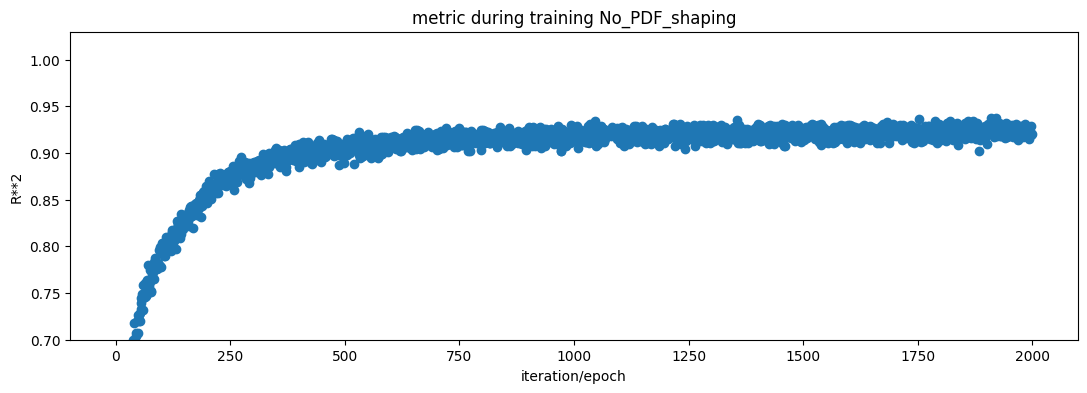

Training loss: tensor(0.0654, grad_fn=<MseLossBackward0>)
Training R**2: 0.928283663941792
Test loss - scaled: tensor(0.0764, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.2879, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9152176200649317
Testing R**2 - descaled: 0.915217627422392
*****
*****
Testing R**2 - Output: 0 o_y 0.915217627422392


In [27]:



model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [28]:
list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(11.078529, 11.146)
**************************************************
preds, real
(12.673993, 12.515)
**************************************************
preds, real
(11.738786, 12.194)
**************************************************
preds, real
(8.579418, 8.5604)
**************************************************
preds, real
(13.750106, 13.024)
**************************************************
preds, real
(8.084271, 8.2745)
**************************************************
preds, real
(11.2400255, 11.124)
**************************************************
preds, real
(10.304101, 9.8588)
**************************************************
preds, real
(9.156785, 9.4111)
**************************************************
preds, real
(9.95372, 9.4745)
**************************************************
preds, real
(10.820464, 10.768)
**************************************************
preds, real
(12.591325, 11.999)
********

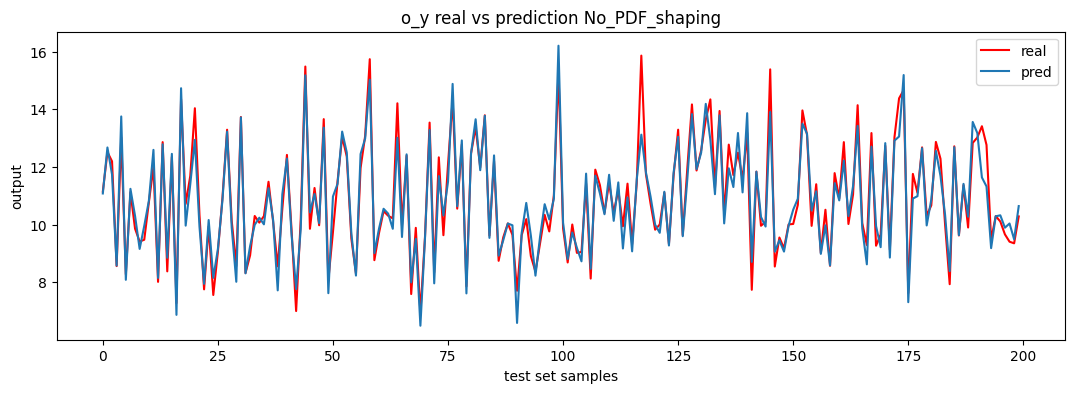

/Users/user/Desktop/DOE_CIVS/experiments/2023april/PDFshapingUtils.py:339: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


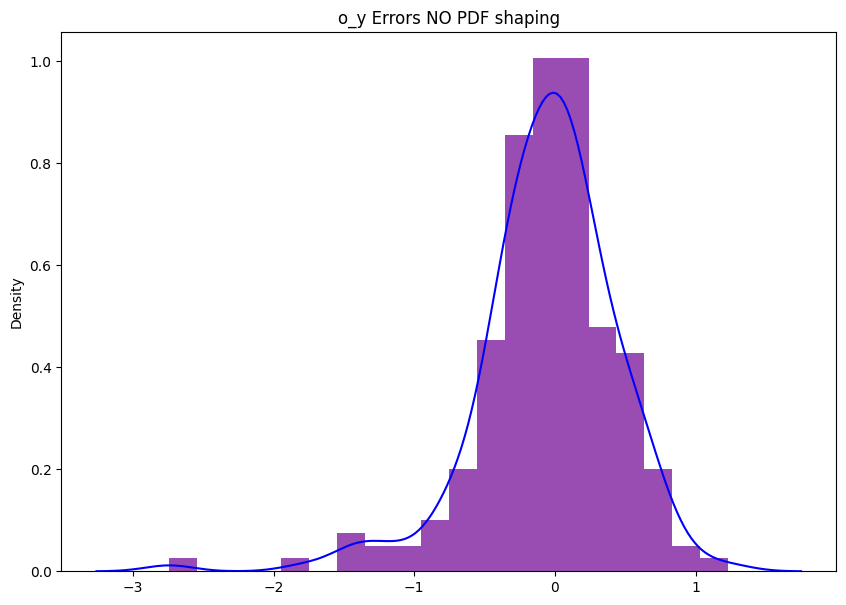

In [29]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

In [30]:

def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, opt, modelSigma, opt_sigma):
    
    PDFshapingOBJ.list_metric = []
    
    PDFshapingOBJ.initializeSigmaVector()
   
    
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(r2_avg.detach().numpy())
        
        
    ## opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        pred_sigma_vector = modelSigma(  PDFshapingOBJ.x_range_impulse_func  )
        PDFshapingOBJ.sigma_func_vector_vals = pred_sigma_vector
        
        error     = pred_scaled.float() - PDFshapingOBJ.y_train_tr_scaled.float()        ## 524  X 6
        basisFunc = PDFshapingOBJ.train_multiple_kernels_per_output( error )         ## 4000 x 6
        
        diff = ( basisFunc.float() - PDFshapingOBJ.impulse_func_vector_vals.unsqueeze(1).float() )  ## 4000 x 6

        ## diff = diff * PDFshapingOBJ.sigma_func_vector_vals.unsqueeze(1)   ## sigma weightinng const
        ## diff = diff * pred_sigma_vector.unsqueeze(1)                         ## 4000 x 1 NN sigma weightinng
        ## diff = diff * pred_sigma_vector.reshape((4000,6))                 ## 4000 x 6 NN sigma weightinng
        
        
        loss = torch.mean(   (   diff  )**2    )  
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        
        opt_sigma.step()
        opt_sigma.zero_grad()
        
  
        print(epoch, " loss= ", loss)
        if epoch % 200 == 0:
            print(error.shape)
            print(basisFunc.shape)
            PDFshapingOBJ.print_errors_kdes(  error, basisFunc )
            print(PDFshapingOBJ.impulse_func_vector_vals.shape)
      

        r2_avg = torch.mean(torch.tensor(
                 r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
        
        
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,       PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy() ))
    

In [31]:
PDFshapingOBJ.the_string           = "With_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

0  loss=  tensor(0.9510, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1426, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0967, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.0949, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.1230, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.0252, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0542, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0340, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0780, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0856, grad_fn=<MseLossBackward0>)
0  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([4000, 1])


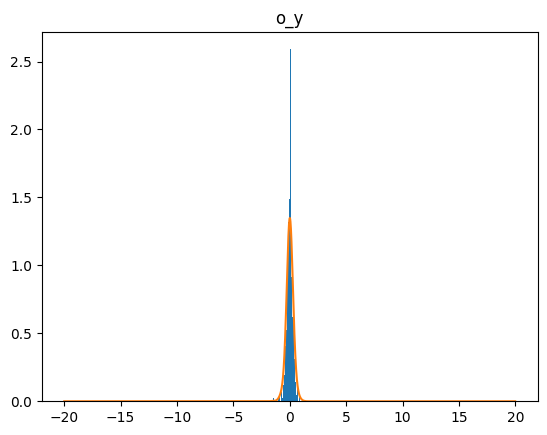

torch.Size([4000])
1  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
4  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
5  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
6  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
8  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
9  loss=  tensor(0.0307, grad_fn=<MeanBackward0>)
10  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
11  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
12  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
13  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
14  loss=  tensor(0.0311, grad_fn=<MeanBackward0>)
15  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
16  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
17  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
18  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
19  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
20  loss=  tensor(0.0

163  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
164  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
165  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
166  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
167  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
168  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
169  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
170  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
171  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
172  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
173  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
174  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
175  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
176  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
177  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
178  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
179  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
180  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
181  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
182  loss=  

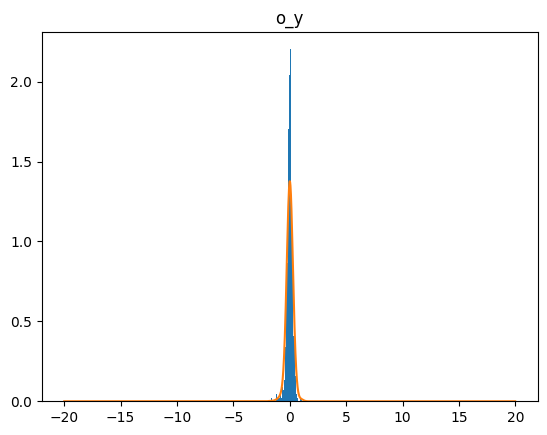

torch.Size([4000])
201  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
202  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
203  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
204  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
205  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
206  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
207  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
208  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
209  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
210  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
211  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
212  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
213  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
214  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
215  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
216  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
217  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
218  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
219  loss=  tensor(0.0301, grad_fn=<MeanBackw

364  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
365  loss=  tensor(0.0307, grad_fn=<MeanBackward0>)
366  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
367  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
368  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
369  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
370  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
371  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
372  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
373  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
374  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
375  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
376  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
377  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
378  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
379  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
380  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
381  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
382  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
383  loss=  

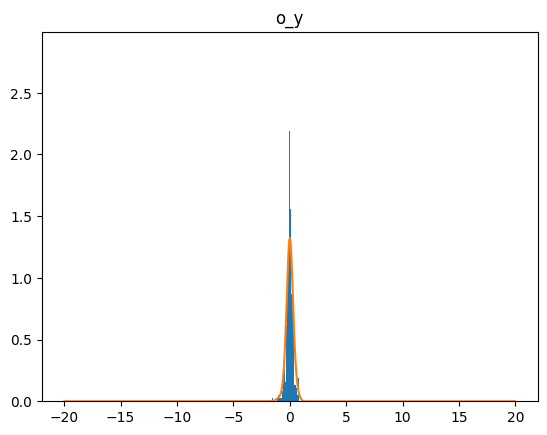

torch.Size([4000])
401  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
402  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
403  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
404  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
405  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
406  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
407  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
408  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
409  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
410  loss=  tensor(0.0306, grad_fn=<MeanBackward0>)
411  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
412  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
413  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
414  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
415  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
416  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
417  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
418  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
419  loss=  tensor(0.0290, grad_fn=<MeanBackw

560  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
561  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
562  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
563  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
564  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
565  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
566  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
567  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
568  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
569  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
570  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
571  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
572  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
573  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
574  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
575  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
576  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
577  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
578  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
579  loss=  

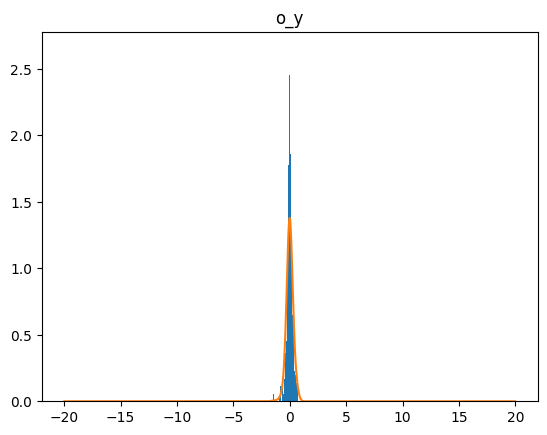

torch.Size([4000])
601  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
602  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
603  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
604  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
605  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
606  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
607  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
608  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
609  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
610  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
611  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
612  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
613  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
614  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
615  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
616  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
617  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
618  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
619  loss=  tensor(0.0295, grad_fn=<MeanBackw

765  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
766  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
767  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
768  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
769  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
770  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
771  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
772  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
773  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
774  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
775  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
776  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
777  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
778  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
779  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
780  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
781  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
782  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
783  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
784  loss=  

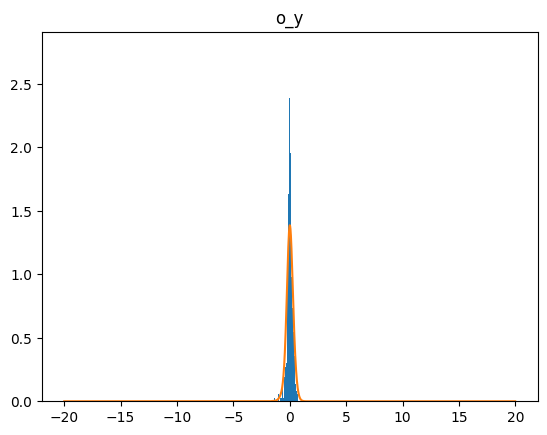

torch.Size([4000])
801  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
802  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
803  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
804  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
805  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
806  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
807  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
808  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
809  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
810  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
811  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
812  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
813  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
814  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
815  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
816  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
817  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
818  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
819  loss=  tensor(0.0291, grad_fn=<MeanBackw

960  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
961  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
962  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
963  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
964  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
965  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
966  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
967  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
968  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
969  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
970  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
971  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
972  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
973  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
974  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
975  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
976  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
977  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
978  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
979  loss=  

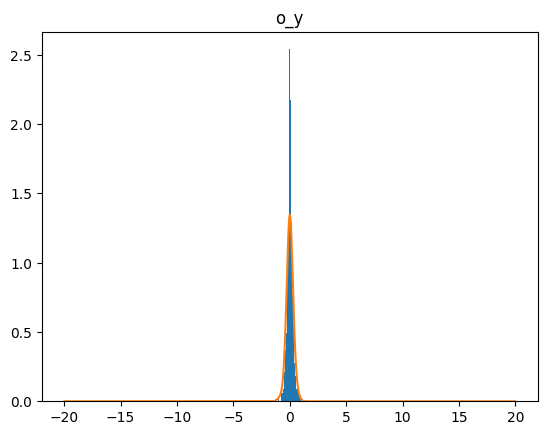

torch.Size([4000])
1001  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1002  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1003  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1004  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1005  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1006  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1007  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1008  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1009  loss=  tensor(0.0279, grad_fn=<MeanBackward0>)
1010  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1011  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
1012  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1013  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1014  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1015  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1016  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1017  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
1018  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
1019  loss=  tensor(0.0294,

1160  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
1161  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
1162  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1163  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1164  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1165  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1166  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1167  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1168  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1169  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1170  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1171  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1172  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1173  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1174  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1175  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1176  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1177  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1178  loss=  tensor(0.0293, grad_fn=<MeanBackw

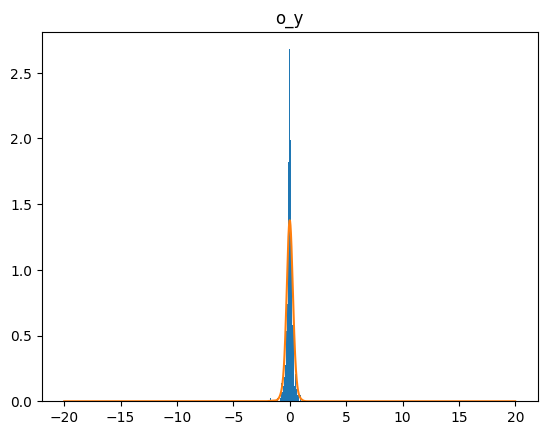

torch.Size([4000])
1201  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1202  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1203  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1204  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1205  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
1206  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1207  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1208  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1209  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1210  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
1211  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1212  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
1213  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
1214  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1215  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1216  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1217  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1218  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1219  loss=  tensor(0.0295,

1365  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
1366  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
1367  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1368  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1369  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
1370  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1371  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1372  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
1373  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1374  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1375  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1376  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1377  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1378  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1379  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1380  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1381  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1382  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1383  loss=  tensor(0.0289, grad_fn=<MeanBackw

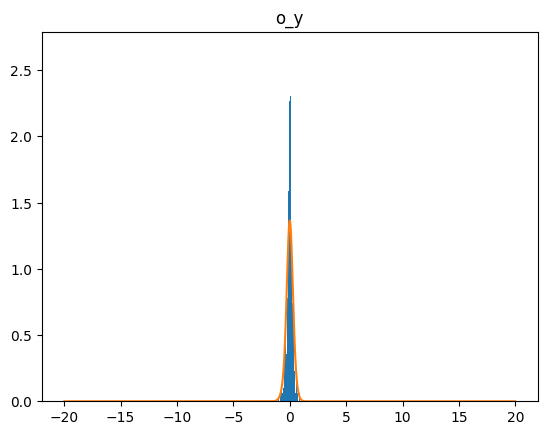

torch.Size([4000])
1401  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1402  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1403  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
1404  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
1405  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1406  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1407  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1408  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1409  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1410  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1411  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1412  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1413  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
1414  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
1415  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1416  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1417  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1418  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1419  loss=  tensor(0.0292,

1560  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1561  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1562  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
1563  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1564  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1565  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
1566  loss=  tensor(0.0306, grad_fn=<MeanBackward0>)
1567  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1568  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1569  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1570  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1571  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1572  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1573  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1574  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1575  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1576  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1577  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1578  loss=  tensor(0.0293, grad_fn=<MeanBackw

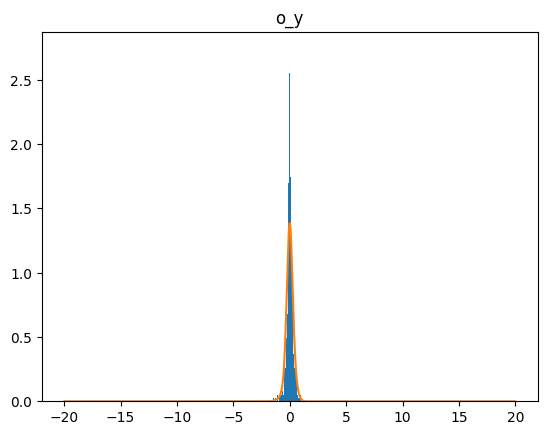

torch.Size([4000])
1601  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1602  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
1603  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1604  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
1605  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1606  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1607  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1608  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1609  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1610  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
1611  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1612  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
1613  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1614  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1615  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1616  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1617  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1618  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1619  loss=  tensor(0.0289,

1760  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1761  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1762  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
1763  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1764  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1765  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1766  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1767  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
1768  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1769  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1770  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1771  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1772  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1773  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1774  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
1775  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1776  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1777  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1778  loss=  tensor(0.0299, grad_fn=<MeanBackw

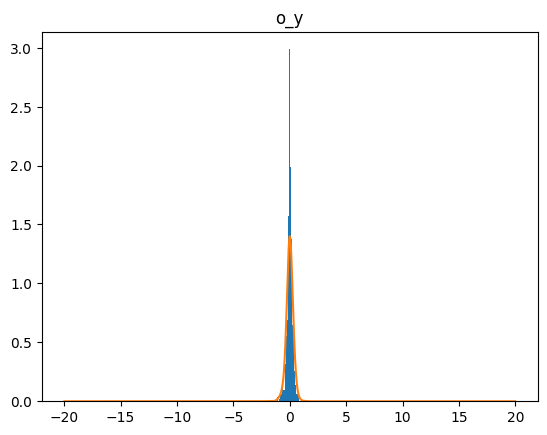

torch.Size([4000])
1801  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1802  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
1803  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1804  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1805  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
1806  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1807  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1808  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1809  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1810  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1811  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1812  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
1813  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1814  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
1815  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
1816  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1817  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
1818  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
1819  loss=  tensor(0.0296,

1956  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1957  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1958  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
1959  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
1960  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1961  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
1962  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
1963  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1964  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
1965  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1966  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1967  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
1968  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
1969  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
1970  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1971  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
1972  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
1973  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
1974  loss=  tensor(0.0303, grad_fn=<MeanBackw

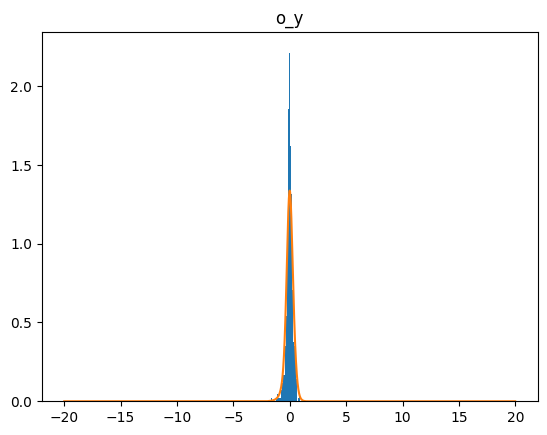

torch.Size([4000])
2001  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2002  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2003  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2004  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2005  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2006  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2007  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2008  loss=  tensor(0.0305, grad_fn=<MeanBackward0>)
2009  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
2010  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2011  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2012  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2013  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2014  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
2015  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2016  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2017  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2018  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2019  loss=  tensor(0.0292,

2156  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
2157  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2158  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2159  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2160  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2161  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
2162  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2163  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2164  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
2165  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2166  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
2167  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2168  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2169  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2170  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2171  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2172  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2173  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2174  loss=  tensor(0.0290, grad_fn=<MeanBackw

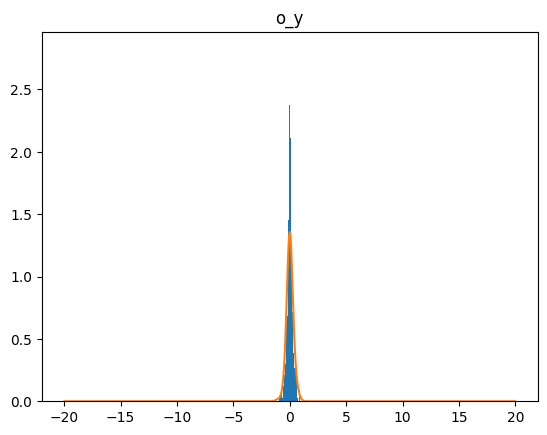

torch.Size([4000])
2201  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
2202  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2203  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
2204  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2205  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2206  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2207  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2208  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2209  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
2210  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
2211  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2212  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2213  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
2214  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
2215  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2216  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2217  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2218  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2219  loss=  tensor(0.0296,

2357  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2358  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2359  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2360  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2361  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
2362  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2363  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2364  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2365  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2366  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2367  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
2368  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
2369  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
2370  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2371  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2372  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2373  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2374  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2375  loss=  tensor(0.0300, grad_fn=<MeanBackw

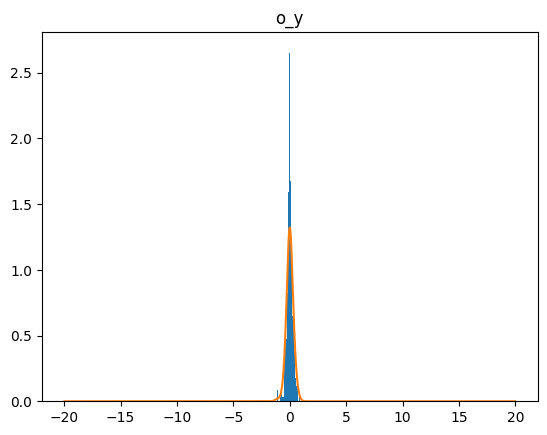

torch.Size([4000])
2401  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2402  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2403  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2404  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2405  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2406  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2407  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
2408  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2409  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2410  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
2411  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2412  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2413  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
2414  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2415  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
2416  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2417  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
2418  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2419  loss=  tensor(0.0289,

2563  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2564  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2565  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
2566  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2567  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2568  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
2569  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
2570  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2571  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2572  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2573  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
2574  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2575  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2576  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
2577  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2578  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2579  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2580  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
2581  loss=  tensor(0.0283, grad_fn=<MeanBackw

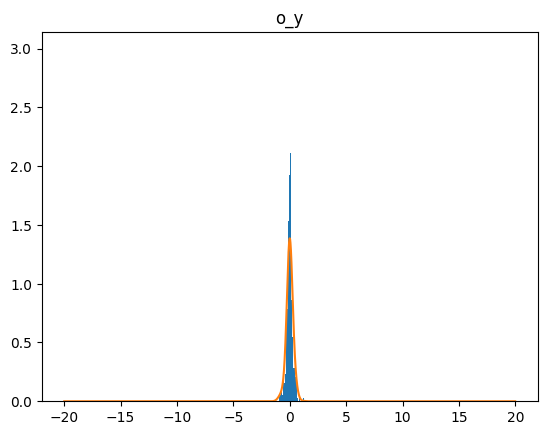

torch.Size([4000])
2601  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2602  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2603  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2604  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2605  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
2606  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
2607  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
2608  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2609  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2610  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
2611  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2612  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2613  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
2614  loss=  tensor(0.0306, grad_fn=<MeanBackward0>)
2615  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2616  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2617  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2618  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2619  loss=  tensor(0.0280,

2761  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2762  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2763  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2764  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2765  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2766  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
2767  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2768  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
2769  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2770  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
2771  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
2772  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2773  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2774  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2775  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
2776  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2777  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
2778  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2779  loss=  tensor(0.0296, grad_fn=<MeanBackw

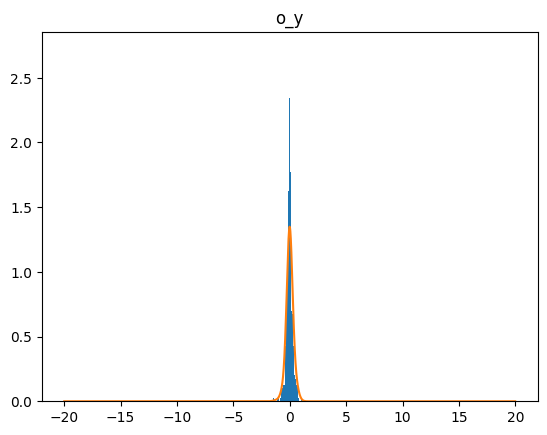

torch.Size([4000])
2801  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2802  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2803  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2804  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2805  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2806  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
2807  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
2808  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2809  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2810  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2811  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
2812  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
2813  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
2814  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2815  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2816  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2817  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2818  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2819  loss=  tensor(0.0291,

2963  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
2964  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2965  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2966  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
2967  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2968  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
2969  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
2970  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
2971  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
2972  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
2973  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
2974  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
2975  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
2976  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
2977  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
2978  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
2979  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
2980  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
2981  loss=  tensor(0.0290, grad_fn=<MeanBackw

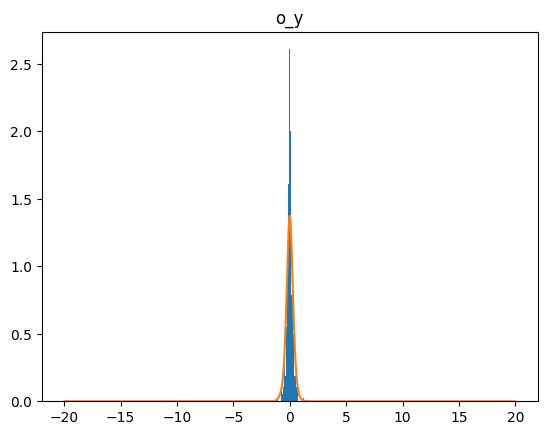

torch.Size([4000])
3001  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3002  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3003  loss=  tensor(0.0309, grad_fn=<MeanBackward0>)
3004  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
3005  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3006  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3007  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3008  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3009  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3010  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3011  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3012  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
3013  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3014  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
3015  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3016  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3017  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
3018  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3019  loss=  tensor(0.0299,

3165  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
3166  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3167  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3168  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3169  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3170  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3171  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3172  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
3173  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3174  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3175  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
3176  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
3177  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3178  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3179  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3180  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3181  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
3182  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
3183  loss=  tensor(0.0300, grad_fn=<MeanBackw

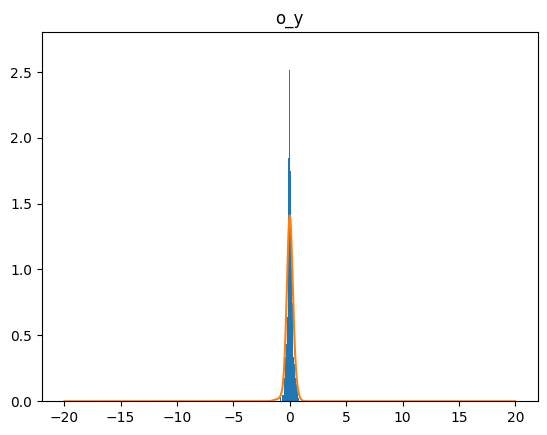

torch.Size([4000])
3201  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3202  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
3203  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
3204  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3205  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3206  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3207  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3208  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
3209  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3210  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
3211  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3212  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3213  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3214  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3215  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3216  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
3217  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3218  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
3219  loss=  tensor(0.0294,

3356  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3357  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3358  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
3359  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3360  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3361  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3362  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3363  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3364  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3365  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
3366  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3367  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3368  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3369  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3370  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
3371  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3372  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3373  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3374  loss=  tensor(0.0298, grad_fn=<MeanBackw

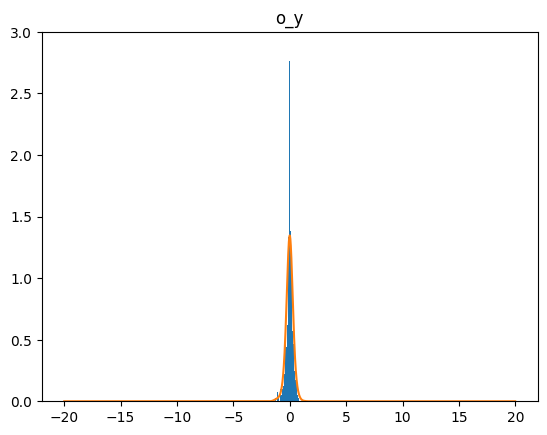

torch.Size([4000])
3401  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3402  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3403  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3404  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3405  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3406  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3407  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
3408  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3409  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
3410  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3411  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3412  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3413  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3414  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
3415  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
3416  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
3417  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3418  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3419  loss=  tensor(0.0293,

3557  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3558  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3559  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
3560  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3561  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
3562  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3563  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
3564  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
3565  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3566  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
3567  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3568  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3569  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
3570  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3571  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3572  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3573  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3574  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
3575  loss=  tensor(0.0299, grad_fn=<MeanBackw

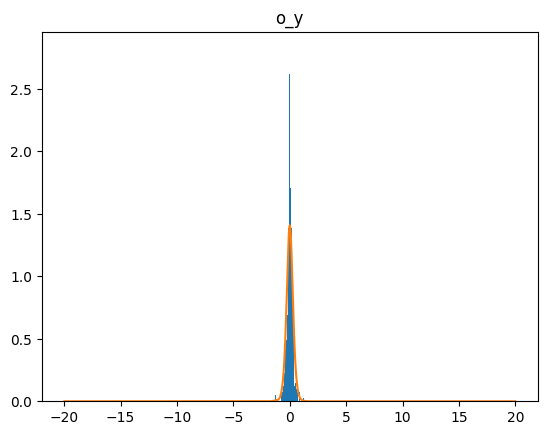

torch.Size([4000])
3601  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3602  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
3603  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3604  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3605  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3606  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3607  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3608  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3609  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
3610  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3611  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3612  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
3613  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3614  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3615  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3616  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3617  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3618  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3619  loss=  tensor(0.0299,

3765  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3766  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3767  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
3768  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3769  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3770  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3771  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3772  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3773  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3774  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3775  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3776  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
3777  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
3778  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3779  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3780  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3781  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3782  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3783  loss=  tensor(0.0294, grad_fn=<MeanBackw

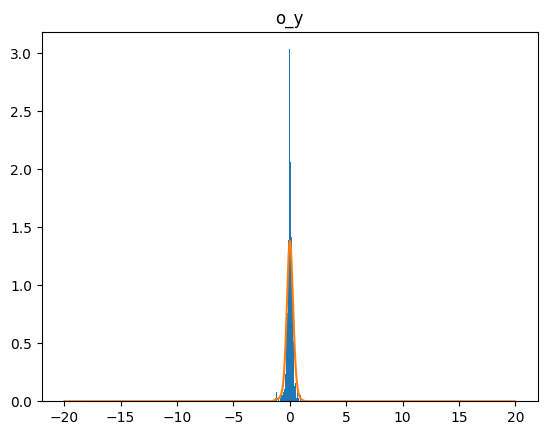

torch.Size([4000])
3801  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3802  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3803  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3804  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3805  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3806  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3807  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3808  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
3809  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3810  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3811  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3812  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3813  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3814  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3815  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3816  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3817  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
3818  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
3819  loss=  tensor(0.0286,

3961  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3962  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
3963  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3964  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3965  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3966  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
3967  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
3968  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
3969  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
3970  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
3971  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
3972  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
3973  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
3974  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3975  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
3976  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3977  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
3978  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
3979  loss=  tensor(0.0294, grad_fn=<MeanBackw

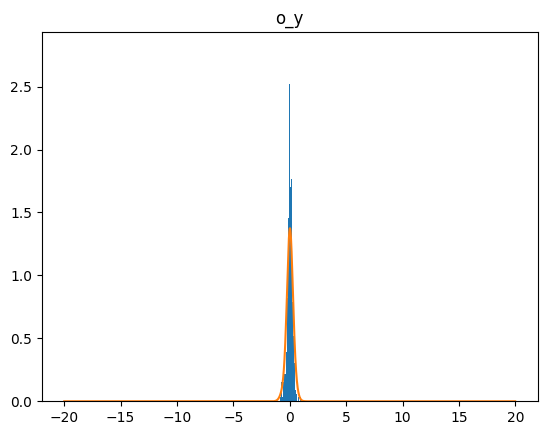

torch.Size([4000])
4001  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
4002  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
4003  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4004  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4005  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4006  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4007  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
4008  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
4009  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
4010  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4011  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4012  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4013  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4014  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4015  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4016  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
4017  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4018  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4019  loss=  tensor(0.0289,

4156  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4157  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
4158  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4159  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
4160  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4161  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
4162  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4163  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4164  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
4165  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4166  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4167  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4168  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4169  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4170  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4171  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4172  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4173  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
4174  loss=  tensor(0.0288, grad_fn=<MeanBackw

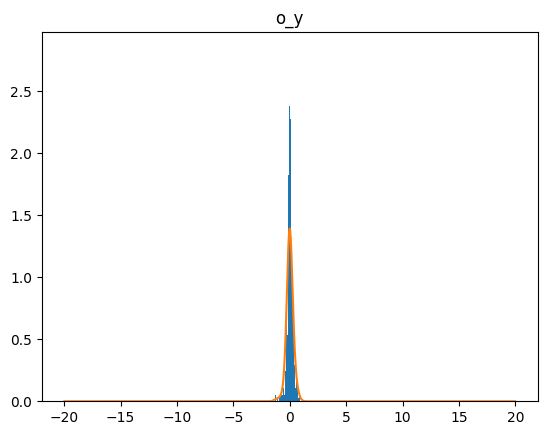

torch.Size([4000])
4201  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4202  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4203  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
4204  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
4205  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
4206  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
4207  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4208  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4209  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4210  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
4211  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
4212  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4213  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
4214  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
4215  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4216  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4217  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4218  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4219  loss=  tensor(0.0293,

4360  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4361  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
4362  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
4363  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4364  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
4365  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4366  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4367  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4368  loss=  tensor(0.0308, grad_fn=<MeanBackward0>)
4369  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4370  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4371  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
4372  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
4373  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4374  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4375  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4376  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4377  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4378  loss=  tensor(0.0293, grad_fn=<MeanBackw

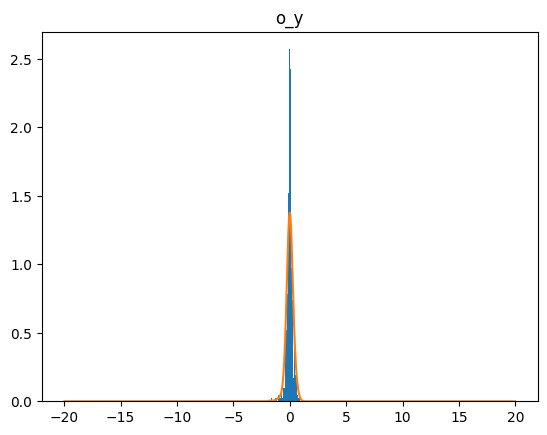

torch.Size([4000])
4401  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4402  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
4403  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4404  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4405  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4406  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
4407  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4408  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4409  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
4410  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4411  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4412  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4413  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4414  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4415  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4416  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
4417  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4418  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4419  loss=  tensor(0.0296,

4560  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4561  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4562  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4563  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4564  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
4565  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4566  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4567  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4568  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4569  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4570  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
4571  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4572  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4573  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
4574  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
4575  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
4576  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4577  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
4578  loss=  tensor(0.0288, grad_fn=<MeanBackw

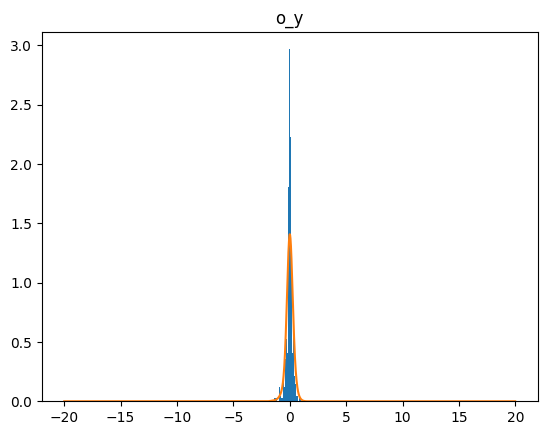

torch.Size([4000])
4601  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4602  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4603  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
4604  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
4605  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4606  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4607  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
4608  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4609  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4610  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4611  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
4612  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4613  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
4614  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4615  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4616  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
4617  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4618  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
4619  loss=  tensor(0.0295,

4761  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
4762  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4763  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4764  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4765  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
4766  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4767  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4768  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4769  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
4770  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4771  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4772  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4773  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4774  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4775  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
4776  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
4777  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4778  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
4779  loss=  tensor(0.0286, grad_fn=<MeanBackw

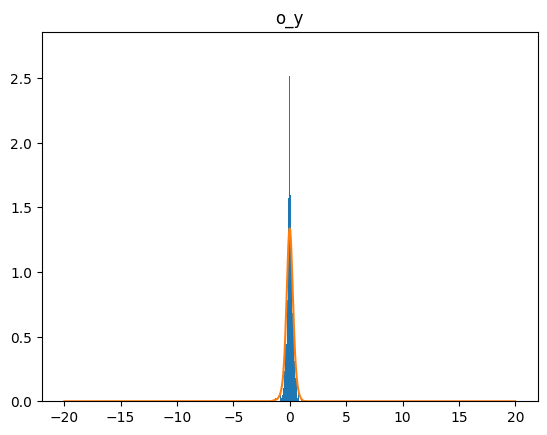

torch.Size([4000])
4801  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4802  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4803  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4804  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4805  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4806  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4807  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4808  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4809  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
4810  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4811  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
4812  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4813  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4814  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
4815  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4816  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4817  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4818  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4819  loss=  tensor(0.0294,

4965  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4966  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
4967  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4968  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
4969  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
4970  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
4971  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
4972  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
4973  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4974  loss=  tensor(0.0278, grad_fn=<MeanBackward0>)
4975  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
4976  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4977  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
4978  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
4979  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
4980  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
4981  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
4982  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
4983  loss=  tensor(0.0289, grad_fn=<MeanBackw

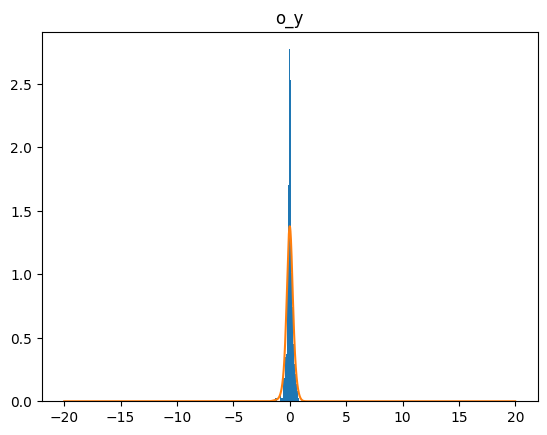

torch.Size([4000])
5001  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5002  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5003  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5004  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5005  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5006  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
5007  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
5008  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5009  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5010  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5011  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
5012  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
5013  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
5014  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
5015  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5016  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5017  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
5018  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
5019  loss=  tensor(0.0290,

5160  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5161  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5162  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5163  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
5164  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5165  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5166  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5167  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5168  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5169  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5170  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
5171  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5172  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5173  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
5174  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5175  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5176  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
5177  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5178  loss=  tensor(0.0285, grad_fn=<MeanBackw

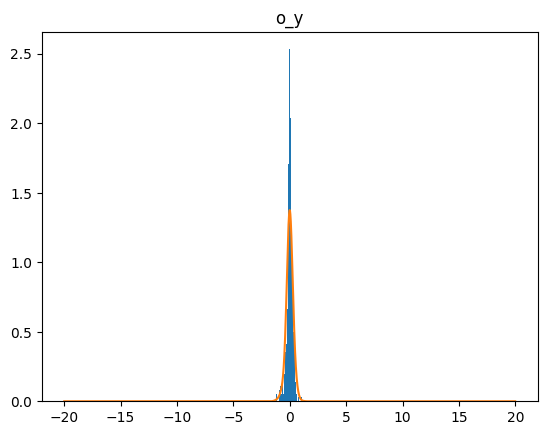

torch.Size([4000])
5201  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5202  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5203  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5204  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5205  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5206  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
5207  loss=  tensor(0.0279, grad_fn=<MeanBackward0>)
5208  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5209  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
5210  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5211  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
5212  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5213  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5214  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5215  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
5216  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5217  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5218  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5219  loss=  tensor(0.0288,

5361  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5362  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5363  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
5364  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
5365  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5366  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
5367  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
5368  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
5369  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
5370  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5371  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5372  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5373  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5374  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5375  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
5376  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5377  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5378  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5379  loss=  tensor(0.0293, grad_fn=<MeanBackw

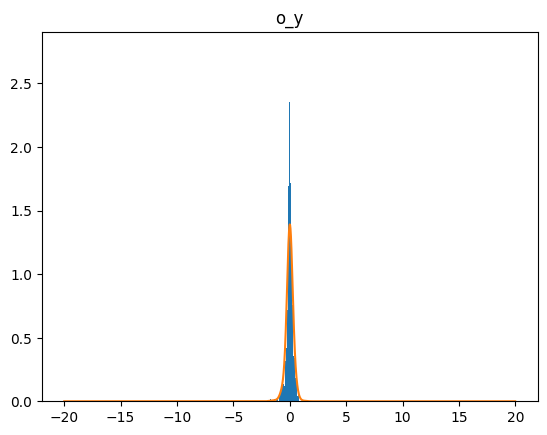

torch.Size([4000])
5401  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
5402  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5403  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5404  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
5405  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5406  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5407  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5408  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5409  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5410  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5411  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5412  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
5413  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
5414  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5415  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5416  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5417  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
5418  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5419  loss=  tensor(0.0286,

5566  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5567  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
5568  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5569  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5570  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5571  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5572  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
5573  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5574  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
5575  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
5576  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5577  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5578  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5579  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
5580  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5581  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5582  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5583  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5584  loss=  tensor(0.0291, grad_fn=<MeanBackw

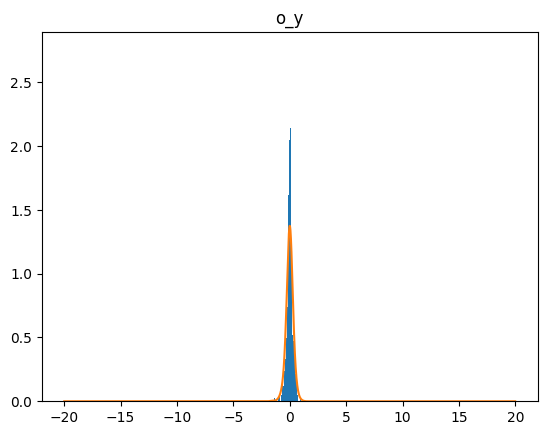

torch.Size([4000])
5601  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5602  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5603  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5604  loss=  tensor(0.0279, grad_fn=<MeanBackward0>)
5605  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
5606  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5607  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
5608  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5609  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5610  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
5611  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5612  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
5613  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
5614  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5615  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5616  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5617  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5618  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
5619  loss=  tensor(0.0289,

5759  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5760  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5761  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5762  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
5763  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5764  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5765  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
5766  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5767  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5768  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5769  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5770  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5771  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5772  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
5773  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5774  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5775  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5776  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
5777  loss=  tensor(0.0293, grad_fn=<MeanBackw

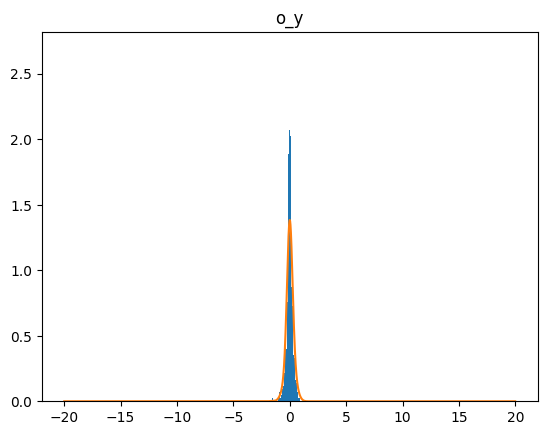

torch.Size([4000])
5801  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5802  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5803  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5804  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
5805  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
5806  loss=  tensor(0.0303, grad_fn=<MeanBackward0>)
5807  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5808  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
5809  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5810  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
5811  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
5812  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5813  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5814  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
5815  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
5816  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
5817  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
5818  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
5819  loss=  tensor(0.0295,

5961  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5962  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
5963  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
5964  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5965  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5966  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
5967  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
5968  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
5969  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
5970  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
5971  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5972  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
5973  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
5974  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
5975  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
5976  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
5977  loss=  tensor(0.0277, grad_fn=<MeanBackward0>)
5978  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
5979  loss=  tensor(0.0282, grad_fn=<MeanBackw

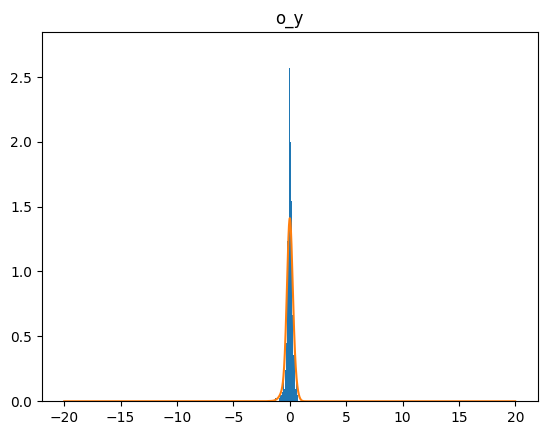

torch.Size([4000])
6001  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6002  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
6003  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6004  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6005  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
6006  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6007  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6008  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6009  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
6010  loss=  tensor(0.0302, grad_fn=<MeanBackward0>)
6011  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6012  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6013  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
6014  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6015  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6016  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6017  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6018  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6019  loss=  tensor(0.0288,

6156  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6157  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6158  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
6159  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6160  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
6161  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6162  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
6163  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6164  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
6165  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6166  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
6167  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6168  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
6169  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6170  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
6171  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6172  loss=  tensor(0.0279, grad_fn=<MeanBackward0>)
6173  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6174  loss=  tensor(0.0285, grad_fn=<MeanBackw

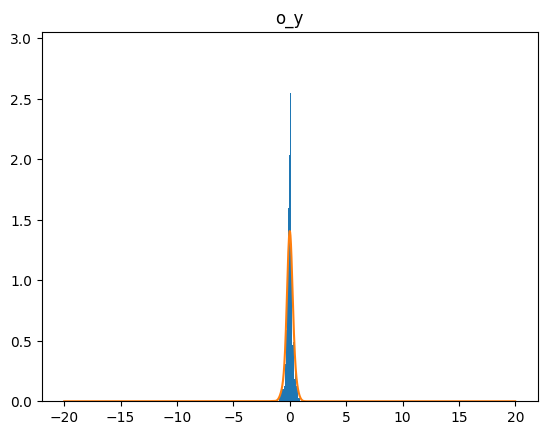

torch.Size([4000])
6201  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
6202  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6203  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6204  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6205  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6206  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
6207  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6208  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6209  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6210  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6211  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
6212  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6213  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6214  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6215  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6216  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
6217  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
6218  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
6219  loss=  tensor(0.0289,

6363  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6364  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
6365  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
6366  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
6367  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6368  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6369  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
6370  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
6371  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6372  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6373  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6374  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6375  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
6376  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6377  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
6378  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6379  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
6380  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6381  loss=  tensor(0.0284, grad_fn=<MeanBackw

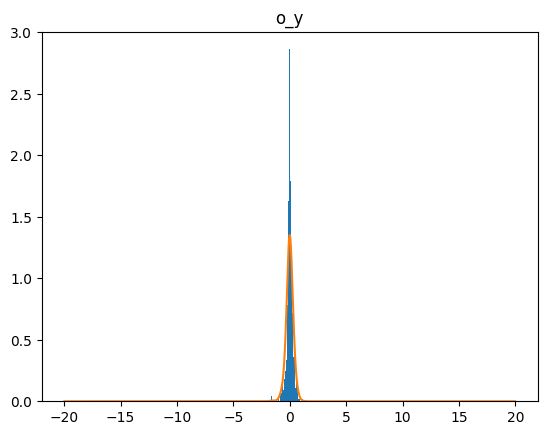

torch.Size([4000])
6401  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
6402  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6403  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6404  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6405  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6406  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6407  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
6408  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6409  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6410  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6411  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6412  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6413  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6414  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6415  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6416  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
6417  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
6418  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6419  loss=  tensor(0.0291,

6565  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6566  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6567  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6568  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6569  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6570  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
6571  loss=  tensor(0.0299, grad_fn=<MeanBackward0>)
6572  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
6573  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6574  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
6575  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6576  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6577  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6578  loss=  tensor(0.0279, grad_fn=<MeanBackward0>)
6579  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6580  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
6581  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6582  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
6583  loss=  tensor(0.0288, grad_fn=<MeanBackw

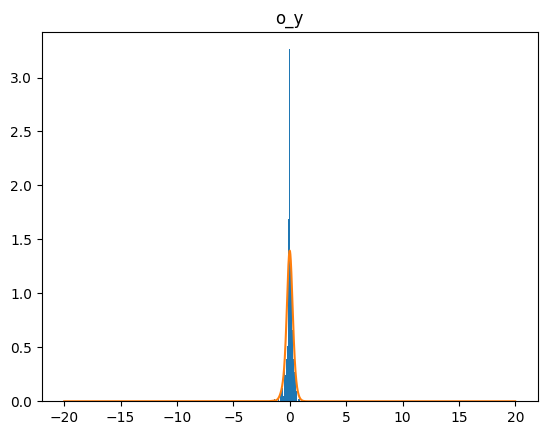

torch.Size([4000])
6601  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6602  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6603  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6604  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6605  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6606  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
6607  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6608  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6609  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6610  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6611  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6612  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
6613  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6614  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
6615  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6616  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
6617  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
6618  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6619  loss=  tensor(0.0289,

6756  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6757  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
6758  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
6759  loss=  tensor(0.0275, grad_fn=<MeanBackward0>)
6760  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6761  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6762  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6763  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6764  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6765  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
6766  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6767  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6768  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6769  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6770  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6771  loss=  tensor(0.0304, grad_fn=<MeanBackward0>)
6772  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6773  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
6774  loss=  tensor(0.0289, grad_fn=<MeanBackw

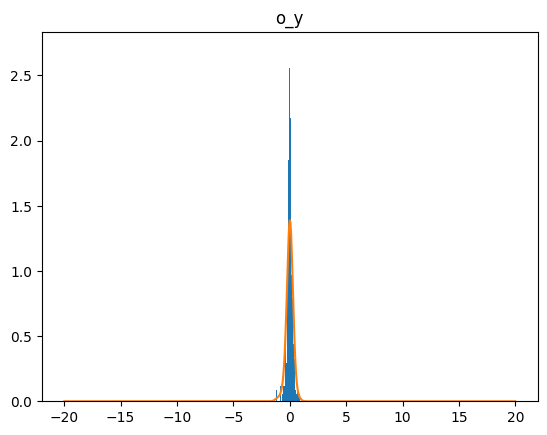

torch.Size([4000])
6801  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
6802  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6803  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6804  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6805  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
6806  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
6807  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6808  loss=  tensor(0.0306, grad_fn=<MeanBackward0>)
6809  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6810  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6811  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
6812  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6813  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
6814  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6815  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6816  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6817  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6818  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6819  loss=  tensor(0.0286,

6958  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6959  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6960  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6961  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6962  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
6963  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
6964  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
6965  loss=  tensor(0.0279, grad_fn=<MeanBackward0>)
6966  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6967  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
6968  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
6969  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6970  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
6971  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6972  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
6973  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
6974  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
6975  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
6976  loss=  tensor(0.0290, grad_fn=<MeanBackw

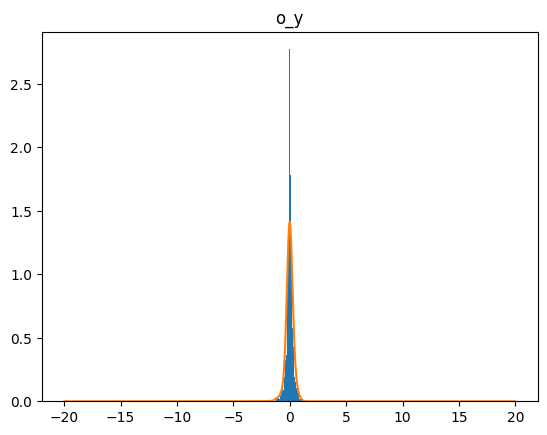

torch.Size([4000])
7001  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7002  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
7003  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7004  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7005  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7006  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
7007  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7008  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7009  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
7010  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
7011  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7012  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7013  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7014  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7015  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7016  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7017  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7018  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7019  loss=  tensor(0.0286,

7156  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7157  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7158  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7159  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7160  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7161  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7162  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
7163  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7164  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
7165  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7166  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7167  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
7168  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
7169  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7170  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7171  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
7172  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7173  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7174  loss=  tensor(0.0289, grad_fn=<MeanBackw

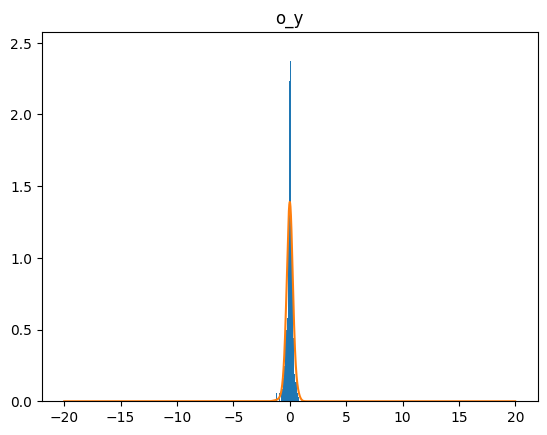

torch.Size([4000])
7201  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
7202  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7203  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7204  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7205  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7206  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7207  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7208  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7209  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7210  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7211  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7212  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7213  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7214  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7215  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7216  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7217  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7218  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7219  loss=  tensor(0.0292,

7357  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
7358  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7359  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7360  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7361  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7362  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7363  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7364  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7365  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
7366  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
7367  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7368  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7369  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7370  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
7371  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7372  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7373  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7374  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7375  loss=  tensor(0.0295, grad_fn=<MeanBackw

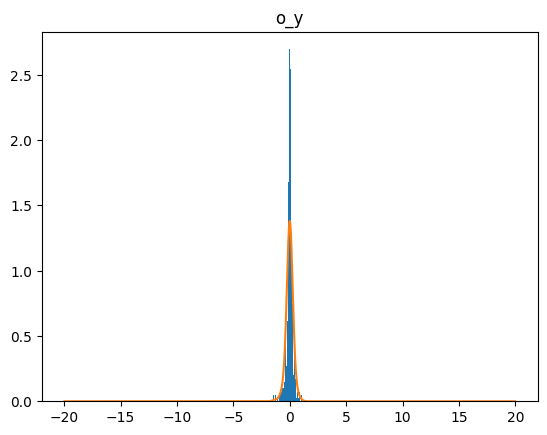

torch.Size([4000])
7401  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7402  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7403  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7404  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7405  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7406  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7407  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7408  loss=  tensor(0.0276, grad_fn=<MeanBackward0>)
7409  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7410  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7411  loss=  tensor(0.0301, grad_fn=<MeanBackward0>)
7412  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
7413  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7414  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7415  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7416  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7417  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
7418  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
7419  loss=  tensor(0.0278,

7557  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7558  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
7559  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7560  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7561  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7562  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7563  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7564  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7565  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
7566  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7567  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7568  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7569  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7570  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7571  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7572  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7573  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7574  loss=  tensor(0.0298, grad_fn=<MeanBackward0>)
7575  loss=  tensor(0.0282, grad_fn=<MeanBackw

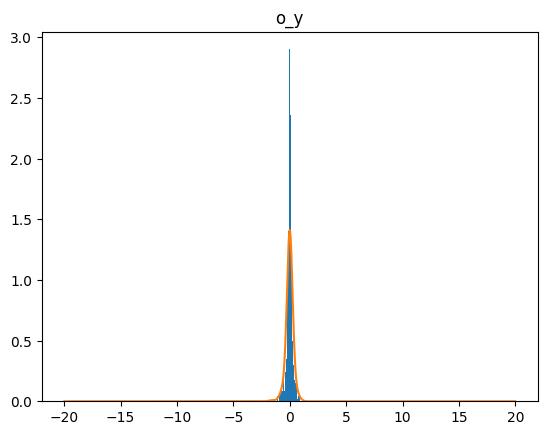

torch.Size([4000])
7601  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7602  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7603  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
7604  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7605  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7606  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
7607  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7608  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7609  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7610  loss=  tensor(0.0282, grad_fn=<MeanBackward0>)
7611  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7612  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7613  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7614  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
7615  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7616  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7617  loss=  tensor(0.0279, grad_fn=<MeanBackward0>)
7618  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7619  loss=  tensor(0.0291,

7758  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
7759  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7760  loss=  tensor(0.0291, grad_fn=<MeanBackward0>)
7761  loss=  tensor(0.0280, grad_fn=<MeanBackward0>)
7762  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7763  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
7764  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7765  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7766  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
7767  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7768  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7769  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7770  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7771  loss=  tensor(0.0296, grad_fn=<MeanBackward0>)
7772  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7773  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7774  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7775  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7776  loss=  tensor(0.0280, grad_fn=<MeanBackw

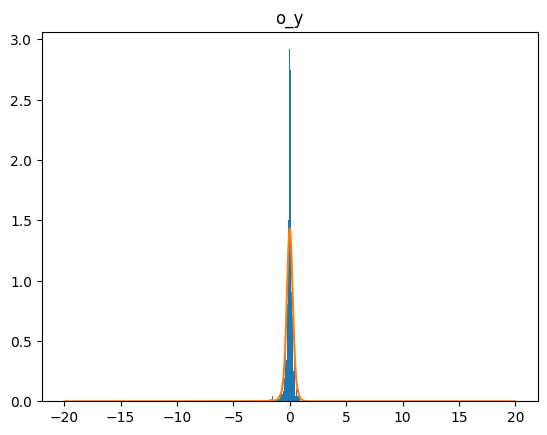

torch.Size([4000])
7801  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7802  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7803  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7804  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7805  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7806  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7807  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7808  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7809  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7810  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7811  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7812  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7813  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
7814  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7815  loss=  tensor(0.0293, grad_fn=<MeanBackward0>)
7816  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7817  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
7818  loss=  tensor(0.0294, grad_fn=<MeanBackward0>)
7819  loss=  tensor(0.0289,

7957  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
7958  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7959  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
7960  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
7961  loss=  tensor(0.0295, grad_fn=<MeanBackward0>)
7962  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
7963  loss=  tensor(0.0290, grad_fn=<MeanBackward0>)
7964  loss=  tensor(0.0300, grad_fn=<MeanBackward0>)
7965  loss=  tensor(0.0283, grad_fn=<MeanBackward0>)
7966  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
7967  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7968  loss=  tensor(0.0288, grad_fn=<MeanBackward0>)
7969  loss=  tensor(0.0297, grad_fn=<MeanBackward0>)
7970  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7971  loss=  tensor(0.0284, grad_fn=<MeanBackward0>)
7972  loss=  tensor(0.0281, grad_fn=<MeanBackward0>)
7973  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
7974  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
7975  loss=  tensor(0.0287, grad_fn=<MeanBackw

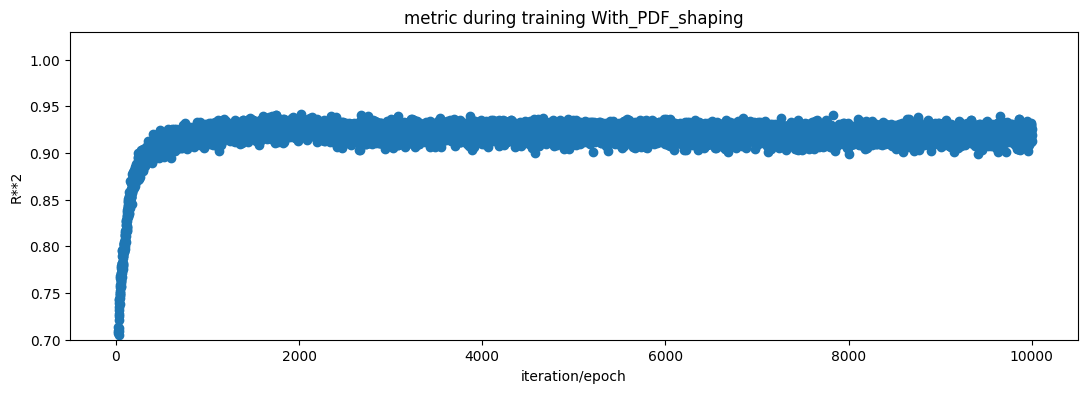

Training loss: tensor(0.0811, grad_fn=<MseLossBackward0>)
Training R**2: 0.9167941448156934
Test loss - scaled: tensor(0.0825, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.3108, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.911506754087842
Testing R**2 - descaled: 0.9115067558310552
*****
*****
Testing R**2 - Output: 0 o_y 0.9115067558310552


In [32]:


PDFshapingOBJ.N_EPOCHS     = 2000                 ## debug, remove                   
PDFshapingOBJ.N_EPOCHS_PDF = 8000              ## debug, remove

modelSigma = SigmaNN()
    

model = F1plusF2_SIO(
          PDFshapingOBJ.x_means, 
          PDFshapingOBJ.x_deviations, 
          PDFshapingOBJ.y_means, 
          PDFshapingOBJ.y_deviations
)


'''
model = LinRegNet_SIO(
          PDFshapingOBJ.x_means, 
          PDFshapingOBJ.x_deviations, 
          PDFshapingOBJ.y_means, 
          PDFshapingOBJ.y_deviations
)
'''

opt       = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
opt_sigma = torch.optim.Adam(   modelSigma.parameters(), lr=PDFshapingOBJ.learning_rate   )

loss_fn     = F.mse_loss


fit_y_scaled_PDF(PDFshapingOBJ.N_EPOCHS, PDFshapingOBJ.N_EPOCHS_PDF, model, loss_fn, opt, modelSigma, opt_sigma)

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,       PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,     PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()   ))


PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


## Now predict on test data

In [33]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(11.386378, 11.146)
**************************************************
preds, real
(12.441399, 12.515)
**************************************************
preds, real
(12.157647, 12.194)
**************************************************
preds, real
(8.888329, 8.5604)
**************************************************
preds, real
(13.38015, 13.024)
**************************************************
preds, real
(9.099266, 8.2745)
**************************************************
preds, real
(11.197685, 11.124)
**************************************************
preds, real
(9.707882, 9.8588)
**************************************************
preds, real
(9.935362, 9.4111)
**************************************************
preds, real
(9.338729, 9.4745)
**************************************************
preds, real
(10.789327, 10.768)
**************************************************
preds, real
(12.175415, 11.999)
**********

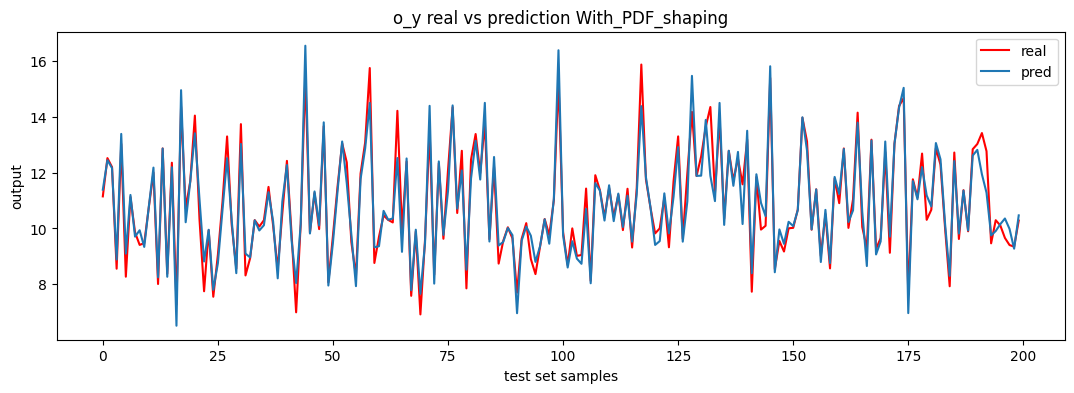

/Users/user/Desktop/DOE_CIVS/experiments/2023april/PDFshapingUtils.py:339: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


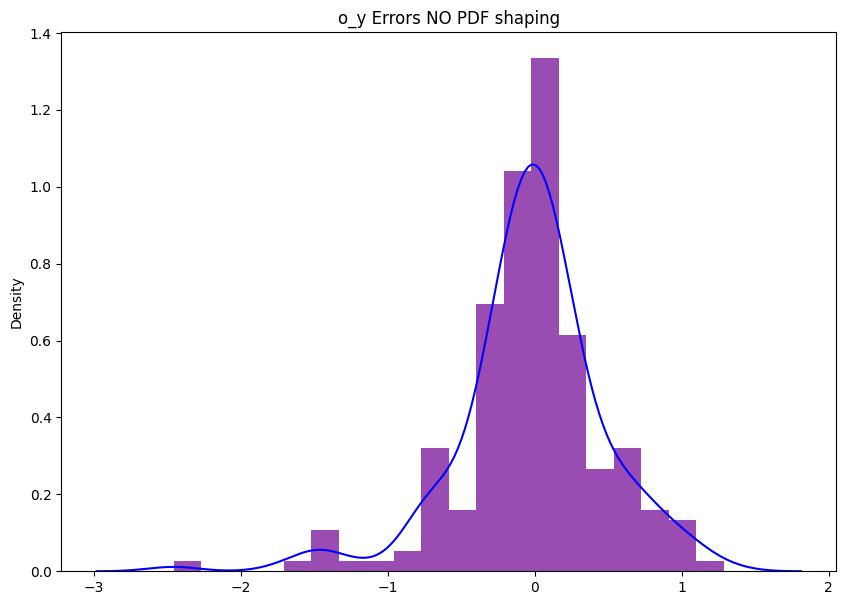

In [34]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Export ONNX model

In [ ]:

'''

model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s536ShaftPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''
